# BE Noté _Machine Learning_

## Partie 1. Analyse de données ISAR

In [91]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

1. On commence par observer la base de données.

F15 162
F16 162
F4 162
A10 162
F14 162


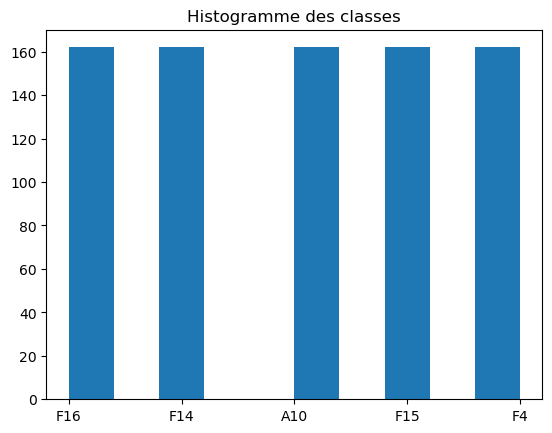

In [92]:
# On charge les noms de fichiers dans une liste
files = os.listdir('images_ISAR')

# les noms sont de la forme classe_nbr.bmp
# on extrait les classes
classes = [f.split('_')[0] for f in files]

# on extrait le nombre d'images par classe
for c in set(classes):
    print(c, classes.count(c))

# Affichage sous forme d'histogramme
plt.hist(classes)
plt.title("Histogramme des classes")
plt.show()


In [93]:
# on charge une image pour analyser l'espace de données
from PIL import Image
img = Image.open('images_ISAR/'+files[0])
img = np.array(img)

print("Dimensions de l'espace de données : ", img.shape)
print("Valeur min : ", img.min())
print("Valeur max : ", img.max())

Dimensions de l'espace de données :  (256, 256)
Valeur min :  0
Valeur max :  255


Dimensions de l'espace de données :  (138, 138)
Gain en taille :  3.4412938458307076


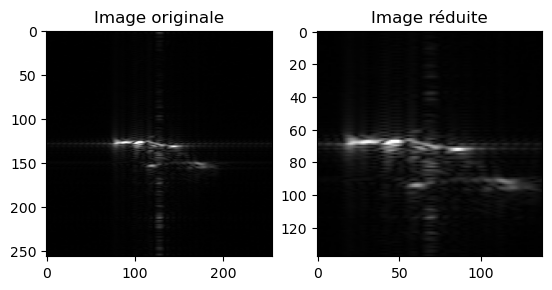

In [94]:
# On commence par réduire la taille des images en ne gardant que le centre, i.e. les valeurs les plus importantes
# on supprime les valeurs inférieures à une valeur donnée, et on garde les autres dans un ndarray de la bonne taille
def crop_image(img, threshold=40):
    res = np.copy(img)
    res[res<threshold] = 0
    res[res>=threshold] = 1
    # on identifie l'image carrée la plus petite contenant toutes les valeurs non nulles

    res = np.where(res==1)
    xmin = min(res[0])
    xmax = max(res[0])
    ymin = min(res[1])
    ymax = max(res[1])
    smin = xmin if (xmax-xmin)>(ymax-ymin) else ymin
    smax = xmax if (xmax-xmin)>(ymax-ymin) else ymax
    ds = min(xmax-xmin, ymax-ymin)
    # centrée
    smin = (smax+smin)//2 - ds//2
    res = img[smin:smin+ds, smin:smin+ds]
    return np.asarray(res, dtype=np.uint8)

# on applique la fonction à l'image de test
img_crop = crop_image(img)
print("Dimensions de l'espace de données : ", img_crop.shape)
print("Gain en taille : ", img.size/img_crop.size)

# on affiche les deux images
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Image originale")
plt.subplot(1,2,2)
plt.imshow(img_crop, cmap='gray')
plt.title("Image réduite")
plt.show()

In [95]:
def adjust_size(img, size):
    # transforme une image en une image de taille size*size
    # en gardant le centre de l'image, et met des 0 autour
    res = np.zeros((size, size), dtype=np.uint8)
    xmax = img.shape[0]
    ymax = img.shape[1]
    x0 = size // 2
    y0 = size // 2
    x1 = x0 - xmax // 2
    y1 = y0 - ymax // 2
    res[x1:x1+xmax, y1:y1+ymax] = img
    return res

In [96]:
def crop_and_normalize(imgs):
    # crops all images in list imgs
    # returns a list of cropped images of same size
    size = 0
    raw_cropped = []
    for img in imgs:
        img_crop = crop_image(img)
        size = max(size, img_crop.shape[0])
        raw_cropped.append(img_crop)
    res = []
    for img in raw_cropped:
        img = adjust_size(img, size)
        res.append(img)
    return np.asarray(res, dtype=np.uint8)

2. On charge toutes les images dans une matrice de données.

In [97]:
# on charge toutes les images dans une matrice de données

# on crée une matrice de données vide
data = np.zeros((len(files), img.shape[0], img.shape[1]), dtype=np.uint8)

# on charge les images
for i, f in enumerate(files):
    img = Image.open('images_ISAR/'+f)
    img = np.array(img)
    data[i] = img

print("Dimensions de la matrice de données : ", data.shape)

# on charge les labels (classes)
labels = np.array(classes)
print("Dimensions du vecteur de labels : ", labels.shape)

Dimensions de la matrice de données :  (810, 256, 256)
Dimensions du vecteur de labels :  (810,)


In [98]:
# on crop toutes les images
data_crop = crop_and_normalize(data)

xmin, ymin = data_crop.shape[1], data_crop.shape[2]

print("Dimensions minimales : ", xmin, ymin)
print("Gain en dimension : ", data.shape[1]*data.shape[2]/(xmin*ymin))


print("Dimensions de la matrice de données : ", data_crop.shape)

Dimensions minimales :  253 253
Gain en dimension :  1.0238560202471527
Dimensions de la matrice de données :  (810, 253, 253)


## Partie 2. Extraction des caractéristiques discriminantes -- image polaire

1. On commence par transformer les images du plan cartésien au plan polaire.

In [99]:
import skimage.transform as skt

def polaire(img, center=None, radius=None):
    # on transforme l'image en image polaire
    return skt.warp_polar(img, center=center, radius=radius)

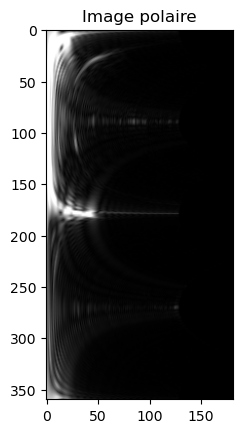

Nouvelle dimension :  (360, 182)


In [100]:
img_polaire = polaire(img)
plt.imshow(img_polaire, cmap='gray')
plt.title("Image polaire")
plt.show()

print("Nouvelle dimension : ", img_polaire.shape)

In [101]:
# on applique la transformation à toutes les images
data_polaires = []
for img in data_crop:
    data_polaires.append(polaire(img))

data_polaires = np.asarray(data_polaires, dtype=np.uint8)

print("Taille de l'espace de représentation : ", data_polaires.shape)

Taille de l'espace de représentation :  (810, 360, 179)


2. On évalue maintenant l'impact de transformations géométriques sur ces images polaires.
On applique pour cela des transformations à une image au hasard, puis on affiche les résultats.

In [102]:
## Définition des transformations géométriques
def rotation(img, angle):
    # on applique une rotation de l'image d'un angle donné
    # on retourne l'image transformée
    return skt.rotate(img, angle)

def change_echelle(img_orig, scale):
    # on applique une transformation d'échelle à une image originale
    # on retourne l'image transformée et sa projection polaire
    return skt.rescale(img_orig, scale), polaire(skt.rescale(img_orig, scale), center = (img_orig.shape[0]//2, img_orig.shape[1]//2), radius = img_orig.shape[0]//2)


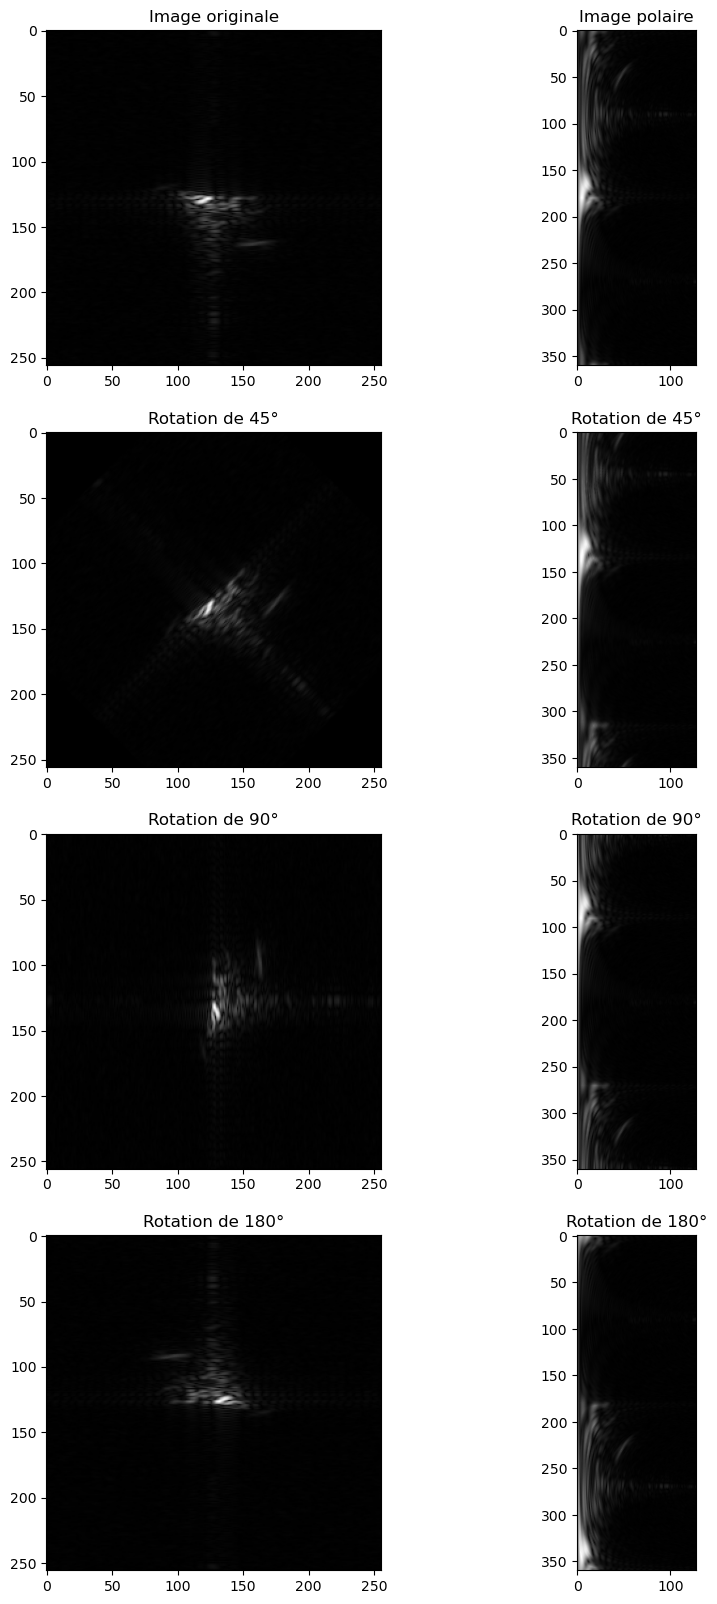

In [103]:
## On applique les transformations à une image au hasard
img = data[6]
img_polaire = polaire(img, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2)

# on applique une rotation
img_rot45 = rotation(img, 45)
img_rot90 = rotation(img, 90)
img_rot180 = rotation(img, 180)
img_pol_rot45 = polaire(img_rot45, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2)
img_pol_rot90 = polaire(img_rot90, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2)
img_pol_rot180 = polaire(img_rot180, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2)

rots = [45, 90, 180]

# on affiche les résultats et on compare les images
fig, ax = plt.subplots(4, 2, figsize=(10, 20))
for i, img in enumerate([img, img_rot45, img_rot90, img_rot180]):
    ax[i, 0].imshow(img, cmap='gray')
    ax[i, 0].set_title("Image originale" if i == 0 else f"Rotation de {rots[i-1]}°")
for i, img in enumerate([img_polaire, img_pol_rot45, img_pol_rot90, img_pol_rot180]):
    ax[i, 1].imshow(img, cmap='gray')
    ax[i, 1].set_title("Image polaire" if i == 0 else f"Rotation de {rots[i-1]}°")
plt.show()

> On remarque que la rotation a un impact faible mais non négligeable sur les images (en-deçà de 180°). En effet, les images polaires sont déformées par la rotation, ce qui peut avoir un impact sur la classification.

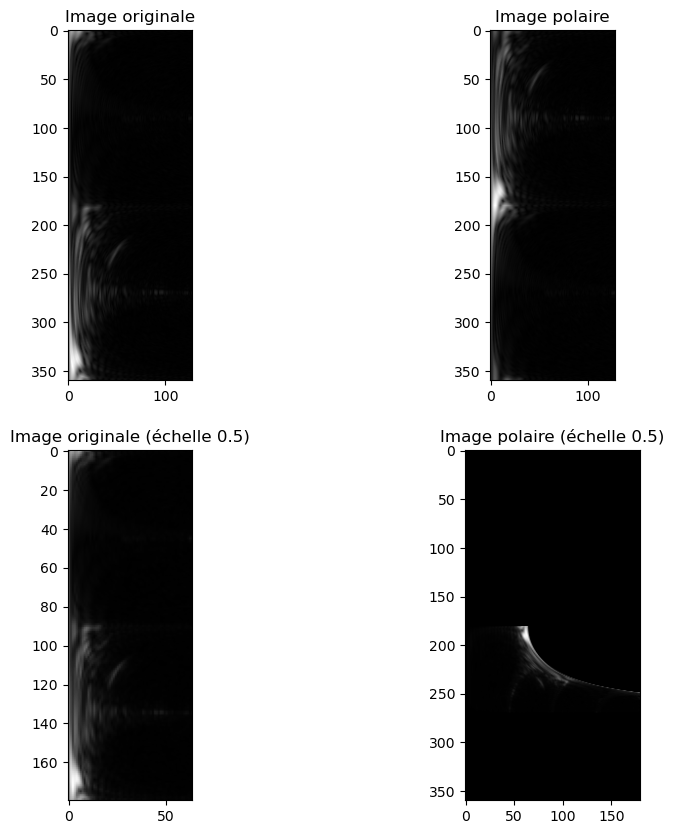

In [104]:
# on applique une transformation d'échelle
img_scale05, img_pol_scale05 = change_echelle(img, 0.5)

# on affiche les résultats et on compare les images
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].set_title("Image originale")
ax[0, 1].imshow(img_polaire, cmap='gray')
ax[0, 1].set_title("Image polaire")
ax[1, 0].imshow(img_scale05, cmap='gray')
ax[1, 0].set_title("Image originale (échelle 0.5)")
ax[1, 1].imshow(img_pol_scale05, cmap='gray')
ax[1, 1].set_title("Image polaire (échelle 0.5)")
plt.show()

> On remarque que la transformation d'échelle a un impact plus important sur les images polaires. En effet, les images polaires sont déformées par la transformation d'échelle, ce qui peut avoir un impact sur la classification.

Pour rendre les résultats invariants par translation, on peut identifier la direction moyenne de l'objet dans l'image originale, et prendre cette direction comme référence.

3. On complète la phase d'extraction, en séparant les caractéristiques par projection sur $r$ et $\theta$.

In [105]:
## Définition des fonctions de projection
def proj_r(img):
    # on projette l'image sur r
    # on retourne le vecteur de projection
    proj = np.sum(img, axis=1)
    # on normalise le vecteur de projection
    return proj / np.linalg.norm(proj)

def proj_theta(img):
    # on projette l'image sur theta
    # on retourne le vecteur de projection
    proj = np.sum(img, axis=0)
    return proj / np.linalg.norm(proj)

In [106]:
def polaire_proj(img, center=(0, 0), radius=1):
    # on applique la transformation polaire à une image
    # on retourne l'image transformée et ses projections sur r et theta
    if center == (0, 0):
        center = (img.shape[0]//2, img.shape[1]//2)
    if radius == 1:
        radius = img.shape[0]//2
    img_polaire = polaire(img, center, radius)
    return img_polaire, proj_r(img_polaire), proj_theta(img_polaire)

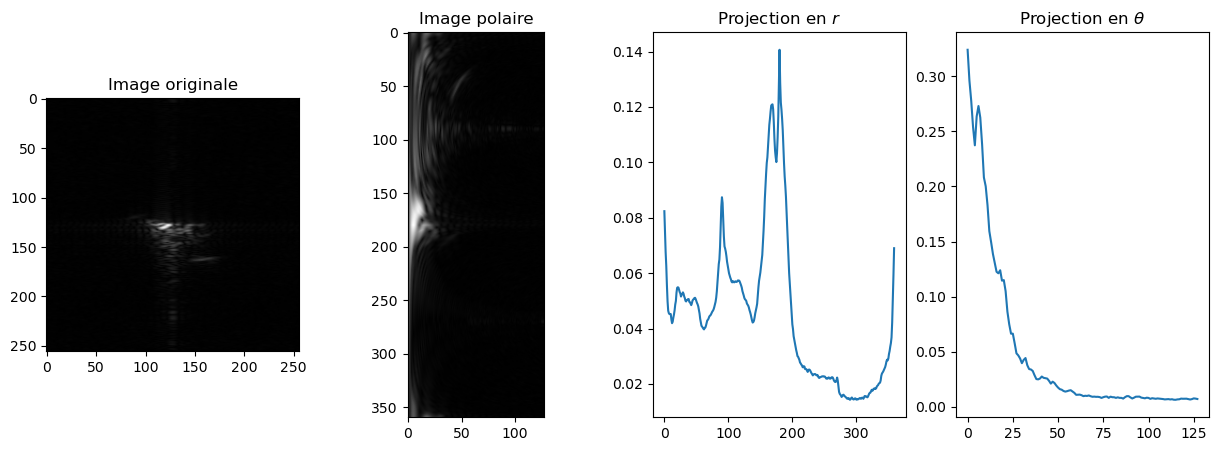

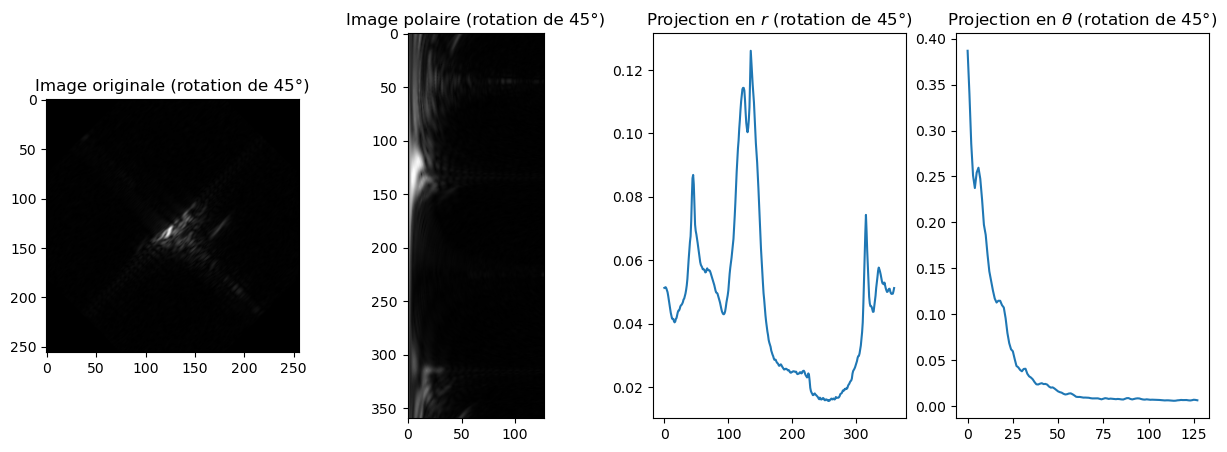

In [107]:
## On applique les transformations à une image au hasard
img = data[6]
pol, projR, projTheta = polaire_proj(img, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2)

# on affiche les résultats originaux
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Image originale")
ax[1].imshow(pol, cmap='gray')
ax[1].set_title("Image polaire")
ax[2].plot(projR)
ax[2].set_title("Projection en $r$")
ax[3].plot(projTheta)
ax[3].set_title("Projection en $\\theta$")
plt.show()

# on applique une rotation
img_rot45 = rotation(img, 45)
pol_rot45, projR_rot45, projTheta_rot45 = polaire_proj(img_rot45, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2)

# on affiche les résultats de la rotation
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].imshow(img_rot45, cmap='gray')
ax[0].set_title("Image originale (rotation de 45°)")
ax[1].imshow(pol_rot45, cmap='gray')
ax[1].set_title("Image polaire (rotation de 45°)")
ax[2].plot(projR_rot45)
ax[2].set_title("Projection en $r$ (rotation de 45°)")
ax[3].plot(projTheta_rot45)
ax[3].set_title("Projection en $\\theta$ (rotation de 45°)")
plt.show()

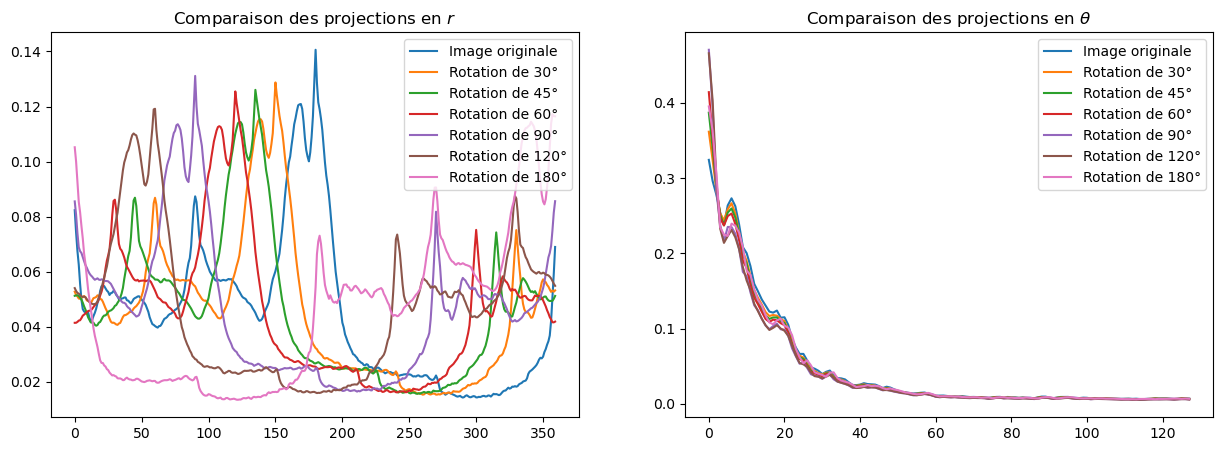

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(projR, label="Image originale")
for theta in [30, 45, 60, 90, 120, 180]:
    img_rot = rotation(img, theta)
    pol_rot, projR_rot, projTheta_rot = polaire_proj(img_rot)
    ax[0].plot(projR_rot, label=f"Rotation de {theta}°")
ax[0].legend()
ax[0].set_title("Comparaison des projections en $r$")
ax[1].plot(projTheta, label="Image originale")
for theta in [30, 45, 60, 90, 120, 180]:
    img_rot = rotation(img, theta)
    pol_rot, projR_rot, projTheta_rot = polaire_proj(img_rot)
    ax[1].plot(projTheta_rot, label=f"Rotation de {theta}°")
ax[1].legend()
ax[1].set_title("Comparaison des projections en $\\theta$")
plt.show()

> On remarque bien l'invariance de la projection sur $\theta$ par rotation, il s'agit donc d'une caractéristique intéressante pour la classification. À noter que la projection sur $r$ ne l'est pas.

Dans le doute, on calcule quand même la distance euclidienne pour voir la similarité entre une image et sa rotation en termes de projection.

In [109]:
# on calcule la distance euclidienne entre les projections
print("Distance en r : " + str(np.linalg.norm(projR - projR_rot45)))
dists = []
for theta in [30, 45, 60, 90, 120, 180]:
    img_rot = rotation(img, theta)
    pol_rot, projR_rot, projTheta_rot = polaire_proj(img_rot)
    dists.append(np.linalg.norm(projTheta - projTheta_rot))
dists = np.array(dists)
print("Distances en theta : " + str(dists))
print("Distance moyenne en theta : " + str(np.mean(dists)))

Distance en r : 0.659353579776706
Distances en theta : [0.05880062 0.09319724 0.13155161 0.21403793 0.22001    0.12930523]
Distance moyenne en theta : 0.14115043788417736


> La distance en $\theta$ reste faible, on peut donc considérer que la projection sur $\theta$ est invariante par rotation.

On continue la comparaison avec une _cross-corrélation_ pour estimer la translation observée sur la projection en $\theta$.

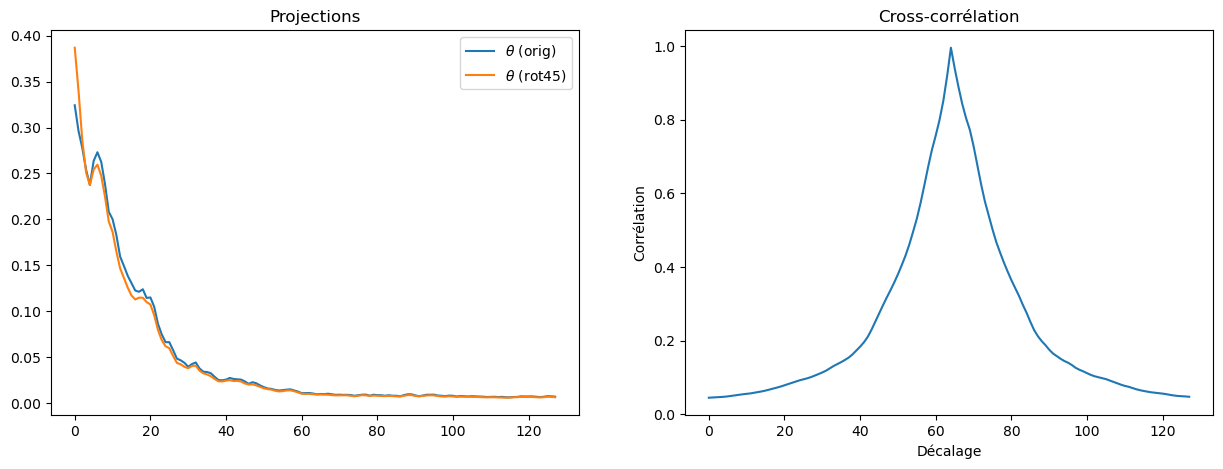

In [110]:
from scipy import signal

# on calcule la cross-corrélation entre les projections
corr = signal.correlate(projTheta, projTheta_rot45, mode='same')
# on affiche les résultats
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(projTheta, label="$\\theta$ (orig)")
ax[0].plot(projTheta_rot45, label="$\\theta$ (rot45)")
ax[0].legend()
ax[0].set_title("Projections")
ax[1].plot(corr)
ax[1].set_xlabel("Décalage")
ax[1].set_ylabel("Corrélation")
ax[1].set_title("Cross-corrélation")
plt.show()

In [111]:
img = data[6]

In [112]:
# on calcule le gain en taille de la projection polaire
print("Gain en taille : " + str(projTheta.shape[0]/(img.shape[0] + projTheta.shape[0])))

Gain en taille : 0.3333333333333333


## Partie 3. Classification : reconnaissance

1. On charge depuis un répertoire donné les images ISAR et on calcule les descripteurs pour chacune d'elles.

In [179]:
from skimage.io import imread

def descripteurs_bdd(dir):
    # on retourne les descripteurs de la base de données
    # on charge les images
    res = []
    for filename in os.listdir(dir):
        img = imread(os.path.join(dir,filename))
        if img is not None:
            res.append(img)
    # on calcule les descripteurs
    descripteurs = []
    for img in res:
        descripteurs.append(polaire_proj(img, center = (img.shape[0]//2, img.shape[1]//2), radius = img.shape[0]//2))
    return np.asarray(descripteurs, dtype=object)


In [180]:
# on charge les images
descripteurs = descripteurs_bdd("images_ISAR")
print("Nombre d'images chargées : " + str(len(descripteurs)))

# matrice data contenant les images, caractéristiques et labels
data = np.zeros((len(descripteurs), 4), dtype=object)
data[:,0] = descripteurs[:,0]
data[:,1] = descripteurs[:,1]
data[:,2] = descripteurs[:,2]
data[:,3] = [filename.split("_")[0] for filename in os.listdir("images_ISAR")]

print("Taille de la matrice data : " + str(data.shape))

Nombre d'images chargées : 810
Taille de la matrice data : (810, 4)


2. On sépare la base de données en base d'apprentissage et base de test (ratio $2/3, 1/3$).

In [181]:
def reconnaissance():
    # on constitue la base d'apprentissage et de test à partir des images chargées (matrice data)
    # ratio 2/3 apprentissage, 1/3 test
    app = data[:int(len(data)*2/3)]
    test = data[int(len(data)*2/3):]
    labels_app = app[:,3]
    labels_test = test[:,3]

    return app, test, labels_app, labels_test

3. On se donne un premier classifieur ($C_1$) qui est un k-plus proches voisins (k-ppv) avec $k$ passé en paramètre, que l'on applique aux projections en $\theta$. On calcule la performance de ce classifieur sur la base de test.

In [238]:
from sklearn.neighbors import KNeighborsClassifier
def classifier1(k):
    # retourne la matrice de distance entre base de test et base d'apprentissage
    return KNeighborsClassifier(n_neighbors=k)


In [259]:
import time
lbls = [label for label in np.unique(data[:,3])]
def exec(classifier, app, test, labels_app, labels_test):
    # on exécute sur les projections en theta
    X_app = np.array([proj.flatten() for proj in app[:,2]])
    X_test = np.array([proj.flatten() for proj in test[:,2]])
    Y_app = np.array([int(lbls.index(label)) for label in labels_app])
    print(X_app.shape, X_test.shape, Y_app.shape)
    classifier.fit(X_app, Y_app)
    return classifier


def performance(classifier, app, test, labels_app, labels_test):
    # on calcule la performance du classifieur sur la base de test
    start = time.time()
    exec(classifier, app, test, labels_app, labels_test)
    X_test = np.array([proj.flatten() for proj in test[:,2]])
    Y_test = np.array([int(lbls.index(label)) for label in labels_test])
    end = time.time()
    score = classifier.score(X_test, Y_test)
    Dt = end - start
    print("Temps d'exécution : " + str(Dt) + "s")
    print("Score : " + str(score))
    return None

In [263]:
# on calcule la performance du classifieur 1 pour k = 1, 3 et 5
app, test, labels_app, labels_test = reconnaissance()

for k in [1, 3, 5]:
    print("*** k = " + str(k) + " ***")
    classifier = classifier1(k)
    performance(classifier, app, test, labels_app, labels_test)

*** k = 1 ***
(540, 128) (270, 128) (540,)
Temps d'exécution : 0.001961946487426758s
Score : 0.9592592592592593
*** k = 3 ***
(540, 128) (270, 128) (540,)
Temps d'exécution : 0.0012791156768798828s
Score : 0.9333333333333333
*** k = 5 ***
(540, 128) (270, 128) (540,)
Temps d'exécution : 0.0010390281677246094s
Score : 0.8851851851851852
